In [1]:
# if torch.cuda.is_available():
#     print('CUDNN VERSION:',torch.backends.cudnn.version())
#     print('Number CUDA Devices:',torch.cuda.device_count())
#     print('CUDA Device Name:',torch.cuda.get_device_name(0))
#     print('CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

In [2]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
# torch.cuda.device_count()

Running on the GPU


In [3]:
import pandas as pd
import numpy as np

Data = pd.read_csv('kuairand_sequence.csv',index_col=0)
print(len(Data))
# Data = pd.read_csv('kuairand_sequence_user=8000.csv',index_col=0)
# data['user_id'].value_counts()

126184


In [4]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader,TensorDataset

max_length = 100
num_user = len(Data['user_id'].unique())
state_feature = len(Data.columns) - 1
action_feature = 3

uid = Data['user_id'].unique()
print(uid.shape)

(6051,)


In [5]:
State = np.zeros(((num_user,max_length,state_feature)))
Action = np.zeros((num_user,max_length,action_feature))
Click = np.zeros((num_user,max_length))

j = 0
for i in uid:
    state_sequence = np.array(Data[Data['user_id']==i])[:-1]
    # state_sequence = np.array(data[data['user_id']==i].drop(['short','mid','long'],axis=1))
    action_sequence = np.array(Data[Data['user_id']==i][['short','mid','long']])[1:]
    click_sequence = np.array(Data[Data['user_id']==i]['is_click'])[1:]
    # action_sequence = np.array(data[data['user_id']==i][['short','mid','long']])
    # print(action_sequence)
    state = np.pad(state_sequence,((0,max_length-len(state_sequence)),(0,0)))[:,1:]
    action = np.pad(action_sequence,((0,max_length-len(action_sequence)),(0,0)))
    click = np.pad(click_sequence,((0,max_length-len(click_sequence))))
    # print(click)
    State[j] = state
    Action[j] = action
    Click[j] = click
    j += 1

# print(len(State))
# print(len(Action))
# print(len(Click))
# print(Click.shape)

In [6]:
length = 20
max_number_traj = 4000

number_traj = 0
def Select_trajectory(X,Y,Z,number_traj):
    Select_states = []
    Select_actions = []
    Select_clicks = []
    # for s in range(number_traj):
    while True:
        i = random.randint(0,len(X)-1)
        select_state = X[i]
        select_action = Y[i]
        select_click = Z[i]
        # print(select_state)
        # print(select_action)
        for k in range(0,max_length):
            # print(select_episode[k])
            if select_state[k].any() == 0:
                max_episode_length = k
                break
        # print(k)
        # print(max_episode_length)
        if max_episode_length >= length + 1:
            j = random.randint(0,max_episode_length-length-1)
            select_state = select_state[j:j+length]
            select_action = select_action[j:j+length]
            select_click = select_click[j:j+length]
            Select_states.append(select_state)
            Select_actions.append(select_action)
            Select_clicks.append(select_click)
            number_traj += 1
        # print(select_trajectory)
        if number_traj == max_number_traj:
            break
    return np.array(Select_states),np.array(Select_actions),np.array(Select_clicks)

X , Y , Z = Select_trajectory(State,Action,Click,number_traj)

In [7]:
np.random.seed(2023)
per = np.random.permutation(X.shape[0])
# print(per)
X = X[per]
Y = Y[per]
Z = Z[per]
X,Y,Z = torch.from_numpy(X).to(torch.float32).to(device),torch.from_numpy(Y).to(torch.float32).to(device), torch.from_numpy(Z).to(torch.float32).to(device)
# print(sum(Y))

In [8]:
def split_data(State, Action, Reward, timestep, input_size, output_size):

    # Training set
    train_size = int(np.round(0.8 * X.shape[0]))
    val_size = int(np.round(0.1 * X.shape[0]))
    print(train_size)

    # Split training and test set 8:1:1
    x_train = X[: train_size, :].reshape(-1, timestep,input_size)
    y_train = Y[: train_size].reshape(-1,timestep, output_size)
    z_train = Z[: train_size].reshape(-1,timestep, 1)

    # x_test = X[train_size:, :].reshape(-1, timestep,input_size)
    # y_test = Y[train_size:].reshape(-1,timestep, output_size)
    # z_test = Z[train_size:].reshape(-1,timestep, 1)

    x_val = X[train_size:train_size+val_size, :].reshape(-1, timestep,input_size)
    y_val = Y[train_size:train_size+val_size].reshape(-1,timestep, output_size)
    z_val = Z[train_size:train_size+val_size].reshape(-1,timestep, 1) 

    x_test = X[train_size+val_size:, :].reshape(-1, timestep,input_size)
    y_test = Y[train_size+val_size:].reshape(-1,timestep, output_size)
    z_test = Z[train_size+val_size:].reshape(-1,timestep, 1)

    return [x_train, y_train, z_train, x_val, y_val, z_val, x_test, y_test, z_test]

# State, Action, Reward(is_click)
X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3 = split_data(X,Y,Z,length,state_feature,action_feature)
# print(X1.shape)
# print(Y1.shape)
# print(Z1.shape)
# X1,Y1=torch.from_numpy(X1).to(torch.float32).to(device),torch.from_numpy(Y1).to(torch.float32).to(device)
# X2,Y2=torch.from_numpy(X2).to(torch.float32).to(device),torch.from_numpy(Y2).to(torch.float32).to(device)
# Z1,Z2=torch.from_numpy(Z1).to(torch.float32).to(device),torch.from_numpy(Z2).to(torch.float32).to(device)
train_ids = TensorDataset(X1,Y1,Z1)
val_ids = TensorDataset(X2,Y2,Z2)
test_ids = TensorDataset(X3,Y3,Z3)
# print(test_ids[0])

3200


In [9]:

from pytorch_tcn.tcn import TCN
x = torch.ones(512,state_feature,length)
model = TCN(state_feature,[512,512],causal=True)
print(model(x).shape)
# model = TCN(
#     num_inputs: int,
#     num_channels: ArrayLike,
#     kernel_size: int = 4,
#     dilations: Optional[ ArrayLike ] = None,
#     dilaton_reset: Optional[ int ] = None,
#     dropout: float = 0.1,
#     causal: bool = True,
#     use_norm: str = 'weight_norm',
#     activation: str = 'relu',
#     kernel_initializer: str = 'xavier_uniform',
#     use_skip_connections: bool = False,
#     input_shape: str = 'NCL',
# )

torch.Size([512, 512, 20])


In [10]:
class MTORL(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, output_size):
        super(MTORL, self).__init__()
        self.hidden_size = hidden_size  # hiddensize
        self.num_layers = num_layers  # gru layer
        # self.embedding = nn.Linear(feature_size,hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.gru = nn.GRU(feature_size, hidden_size, num_layers, batch_first=True)
        # self.lstm = nn.LSTM(feature_size, hidden_size, num_layers, batch_first=True)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc_click = nn.Linear(hidden_size, 1)
        # self.fc1 = nn.Linear(hidden_size, fc_hidden_size)
        # self.fc2 = nn.Linear(fc_hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.ReLU = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU()
        self.BN = nn.BatchNorm1d(8)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.sqrt_size = np.sqrt(hidden_size)
        self.softmax = nn.Softmax(dim=-1)
        self.tcn = TCN(state_feature,[hidden_size,hidden_size])
        # self.multihead = nn.MultiheadAttention(hidden_size,num_heads,dropout=0.1)
    def forward(self, x, hidden=None):
        batch_size = x.shape[0] #  batchsize

        # # initial hidden state
        # if hidden is None:
        #     h_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
        # else:
        #     h_0 = hidden
        # # GRU operation
        # output, h_0 = self.gru(x, h_0)

        # TCN
        x = x.permute(0, 2, 1)
        output = self.tcn(x)
        output = output.permute(0, 2, 1)

        # # Batch Normalization
        # output = self.BN(output)

        # click_prob = self.LeakyReLU(GRU_output)
        # click_prob = click_prob.transpose(0,1)
        click_prob = output.transpose(0,1)

        click_prob = self.hidden(click_prob)
        click_prob = self.LeakyReLU(click_prob)

        click_prob = self.fc_click(click_prob)
        click_prob = self.sigmoid(click_prob)

        # Attention Layer
        query_layer = self.query(output)
        key_layer = self.key(output).permute(0, 2, 1)
        value_layer = self.value(output)
        attention_scores = torch.matmul(query_layer, key_layer)
        attention_scores = attention_scores / self.sqrt_size

        # Mask
        mask = (torch.triu(torch.ones(length, length)) == 0).transpose(0,1).to(device)
        attention_scores = attention_scores.masked_fill(mask, value=torch.tensor(-1e9))
        # print(attention_scores)

        attention_scores = F.dropout(attention_scores, p=0.2)
        attention_probs = self.softmax(attention_scores)
        output = torch.matmul(attention_probs, value_layer)

        # ReLU/LeakyReLU activation
        # output = self.ReLU(output)
        output = self.LeakyReLU(output)
        # output = self.LeakyReLU(GRU_output)


        # # Multihead attention
        # query_layer = self.query(GRU_output)
        # key_layer = self.key(GRU_output)
        # value_layer = self.value(GRU_output)
        # # print(query_layer.shape)
        # output, _ = self.multihead(query_layer,key_layer,value_layer)

        # transpose dim 1,2 to get shape (timestep, batch_size, hidden_dim)
        output = output.transpose(0,1)

        # # Add&Norm (1)
        output = F.dropout(self.LeakyReLU(self.hidden(output)), p=0.2) + output
        output = self.LayerNorm(output)
        output = F.dropout(self.LeakyReLU(self.hidden(output)), p=0.2) + output
        output = self.LayerNorm(output)

        # # Add&Norm (2)
        # output = self.LeakyReLU(self.hidden(output)) + output
        # output = self.LayerNorm(output)
        # output = F.dropout(output, p=0.2)
        # output = self.LeakyReLU(self.hidden(output)) + output
        # output = self.LayerNorm(output)
    
        # # Add&Norm (3)
        # output = F.dropout(output, p=0.2) + GRU_output.transpose(0,1)
        # output = self.LayerNorm(output)
        # output = F.dropout(self.hidden(self.LeakyReLU(self.hidden(output))), p=0.2) + output
        # output = self.LayerNorm(output)

        output = self.fc(output)  # (batch_size, timestep, output_size)

        # Softmax convert to [0,1]
        action_prob = F.softmax(output,dim=2)

        # all timestep output
        return action_prob, click_prob


In [11]:
Batchsize = 512  # 512
# data_train_loader = DataLoader(dataset=train_ids, batch_size=Batchsize, shuffle=True)
data_train_loader = DataLoader(dataset=train_ids, batch_size=Batchsize, shuffle=False)
data_val_loader = DataLoader(dataset=val_ids, batch_size=1, shuffle=False,drop_last=False)
data_test_loader = DataLoader(dataset=test_ids, batch_size=1, shuffle=False,drop_last=False)
# data_full_loader = DataLoader(dataset=data_ids, batch_size=1, shuffle=True)


In [12]:
# def shannon_entropy(x):
#   p = x
#   logp = torch.log2(p)
#   # print(p)
#   # print(logp)
#   entropy = - torch.sum(p*logp,dim=-1)
#   return entropy

In [13]:
import torch
import torch.nn.functional as F

def DPO_loss_func(pi_win,pi_lose):
    # loss = 0
    # num = 0
    # for p_win,p_lose in zip(pi_win,pi_lose):
    #     p_div = F.kl_div(p_win, p_lose)
    #     loss += p_div
    #     num += 1
    div = F.kl_div(pi_lose, pi_win, reduction='batchmean')

    return -torch.log(0.1*F.sigmoid(div))/Batchsize

c:\Users\39223\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss of episode 0 = 24.263517
Loss of episode 1 = 24.184614
Loss of episode 2 = 24.136242
Loss of episode 3 = 24.113409
Loss of episode 4 = 24.092392
Loss of episode 5 = 24.075771
Loss of episode 6 = 24.070318
Loss of episode 7 = 24.070501
Loss of episode 8 = 24.054907
Loss of episode 9 = 24.03629
Loss of episode 10 = 24.007381
Loss of episode 11 = 23.961119
Loss of episode 12 = 23.944418
Loss of episode 13 = 23.926962
Loss of episode 14 = 23.908056
Loss of episode 15 = 23.906414
Loss of episode 16 = 23.891663
Loss of episode 17 = 23.851109
Loss of episode 18 = 23.820768
Loss of episode 19 = 23.805822
Loss of episode 20 = 23.81053
Loss of episode 21 = 23.813513
Loss of episode 22 = 23.756277
Loss of episode 23 = 23.717833
Loss of episode 24 = 23.703566
Loss of episode 25 = 23.718763
Loss of episode 26 = 23.735916
Loss of episode 27 = 23.76248
Loss of episode 28 = 23.696568
Loss of episode 29 = 23.642843
Loss of episode 30 = 23.698166
Loss of episode 31 = 23.624554
Loss of episode 32 = 

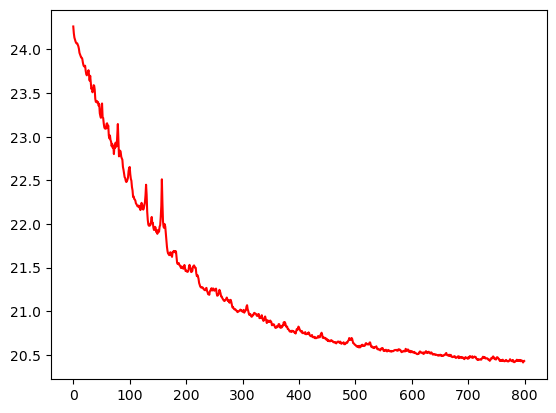

In [14]:
# feature_size, hidden_size, num_layers, output_size, (number_heads)

model = MTORL(state_feature,512,2,3).to(device)
num_epoch = 800     # 800
Lambda = 1.5        # 1.5
Mu = 0.08           # 0.08

# optimizer = torch.optim.SGD(net.parameters(),lr=0.5)
# optimizer = torch.optim.Adam(gru.parameters(),lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)

# loss_func = torch.nn.MSELoss()            #MSE for regression
loss_func = torch.nn.CrossEntropyLoss()     #CE for classification
Loss=[]

for t in range(num_epoch):
    aver_loss = 0
    model.train()
    for batch, data in enumerate(data_train_loader):
        x, y ,z = data
        action_prediction, click_prediction = model(x)
        # print(action_prediction.shape)
        action_prediction = torch.transpose(action_prediction, dim0=0, dim1=1)
        click_prediction = torch.transpose(click_prediction, dim0=0, dim1=1)
        # Entropy = torch.mean(shannon_entropy(action_prediction))
        # loss = loss_func(action_prediction,y) + Mu * loss_func(click_prediction,z) \
        # - Lambda * Entropy 

        # calculate DPO_loss
        click_list = torch.sum(z,dim=1)
        max_index = torch.argmax(click_list)
        min_index = torch.argmin(click_list)
        x_w = x[max_index].unsqueeze(0)
        x_l = x[min_index].unsqueeze(0)
        pi_w, _ = model(x_w)
        pi_l, _ = model(x_l)
        pi_w = pi_w.squeeze(1)
        pi_l = pi_l.squeeze(1)

        # print((pi_w.squeeze(1)).shape)
        # print('-'*100)
        # print(pi_w[0])
        # print(pi_l[0])

        DPO_loss = DPO_loss_func(pi_l,pi_w)
        # print(DPO_loss)

        loss = loss_func(action_prediction,y) + Mu * loss_func(click_prediction,z) + Lambda * DPO_loss
        
        optimizer.zero_grad() 
        loss.backward()    
        optimizer.step() 
        aver_loss += loss
    aver_loss /= batch
    aver_loss=aver_loss.cpu().detach().numpy()
    print('Loss of episode %s ='%t,aver_loss)
    Loss.append(aver_loss)
plt.plot(Loss,color='r')
print()

In [15]:
device = torch.device("cuda")
model_test = MTORL(state_feature,512,2,3).to(device)
total = sum([param.nelement() for param in model_test.parameters()])
print(total)
# gru_test

6680084


## Training accuracy

In [16]:
Truth = []
Pred = []
aver_loss = 0
total_acc = 0
Entropy = 0
model.train()
for batch, data in enumerate(data_train_loader):
# for batch, data in enumerate(data_full_loader):
# for x,y in data_train_loader:
    x, y, z = data
    # print(x)
    # prediction =net(x)
    test, _ = model(x)
    test = torch.transpose(test, dim0=0, dim1=1)
    # print(test)
    # print(y)
    # print(shannon_entropy(test).shape)
    # aver_entropy = sum(torch.mean(shannon_entropy(test),dim=1))
    # Entropy += aver_entropy

    a = torch.argmax(test,dim = 2).cpu().data.numpy()
    b = torch.argmax(y,dim = 2).cpu().data.numpy()
    # print(a)
    # print(b)
    # print(sum(a==b))
    aver_acc = sum(sum(a==b))/length
    # print(aver_acc)
    total_acc += aver_acc
    # print(total_acc)
# print(batch)
print('acc =', total_acc/(0.8*max_number_traj))
# print('Entropy = ', Entropy/(0.8*max_number_traj))

acc = 0.951015625


## Validation accuracy (Hyperparameter tuning)

In [46]:
from sklearn.metrics import roc_curve, auc


Loss=[]
Truth = []
Pred = []
aver_loss = 0
total_acc = 0
total_ctr = 0
total_auc = 0
Entropy = 0
num = 0

# Click_pred = np.zeros((int(0.2*max_number_traj),length))
# Click_true = np.zeros((int(0.2*max_number_traj),length))

for batch, data in enumerate(data_val_loader):
# for batch, data in enumerate(data_full_loader):
# for x,y in data_train_loader:
    model.eval()
    x, y, z = data
    test, click = model(x)
    click_pred = torch.squeeze(click).cpu().data.numpy()
    click_true = torch.squeeze(z).cpu().data.numpy()
    click_pred[click_pred<1/2] = 0
    click_pred[click_pred>=1/2] = 1
    # Click_pred[batch] = click_pred
    # Click_true[batch] = click_true

    p = test[:,0].cpu()
    # aver_entropy = torch.mean(shannon_entropy(p))
    # # print('aver_entropy =', aver_entropy)
    # Entropy += aver_entropy
    # print(test)
    a = torch.argmax(test,dim = 2).cpu().data.numpy().T[0]
    b = torch.argmax(y,dim = 2).cpu().data.numpy()[0]
    # print('-----------')
    # print('pred =',a.T[0])
    # print('true =',b[0])
    aver_acc = sum(a==b)/length
    total_acc += aver_acc

    # print('-----------')
    # print('pred =', click_pred)
    # print('true =', click_true) 
    aver_ctr = sum(click_pred==click_true)/length
    total_ctr += aver_ctr


# fpr, tpr, thresholds = roc_curve(Click_true.reshape(-1), Click_pred.reshape(-1),pos_label=1)
# total_auc = auc(fpr, tpr)
# print('CTR AUC =', total_auc)
print('Action acc =', total_acc/(0.1*max_number_traj))
print('CTR acc =', total_ctr/(0.1*max_number_traj))
# print('Entropy = ', Entropy/(0.1*max_number_traj))


Action acc = 0.6882500000000001
CTR acc = 0.7771250000000002


## Inference accuracy

In [44]:
from sklearn.metrics import roc_curve, auc


Loss=[]
Truth = []
Pred = []
aver_loss = 0
total_acc = 0
total_ctr = 0
total_auc = 0
Entropy = 0
num = 0

# Click_pred = np.zeros((int(0.2*max_number_traj),length))
# Click_true = np.zeros((int(0.2*max_number_traj),length))

for batch, data in enumerate(data_test_loader):
# for batch, data in enumerate(data_full_loader):
# for x,y in data_train_loader:
    model.eval()
    x, y, z = data
    test, click = model(x)
    click_pred = torch.squeeze(click).cpu().data.numpy()
    click_true = torch.squeeze(z).cpu().data.numpy()
    click_pred[click_pred<1/2] = 0
    click_pred[click_pred>=1/2] = 1
    # Click_pred[batch] = click_pred
    # Click_true[batch] = click_true

    p = test[:,0].cpu()
    # aver_entropy = torch.mean(shannon_entropy(p))
    # print('aver_entropy =', aver_entropy)
    # Entropy += aver_entropy
    # print(test)
    a = torch.argmax(test,dim = 2).cpu().data.numpy().T[0]
    b = torch.argmax(y,dim = 2).cpu().data.numpy()[0]
    # print('-----------')
    # print('pred =',a.T[0])
    # print('true =',b[0])
    aver_acc = sum(a==b)/length
    total_acc += aver_acc

    # print('-----------')
    # print('pred =', click_pred)
    # print('true =', click_true) 
    aver_ctr = sum(click_pred==click_true)/length
    total_ctr += aver_ctr


# fpr, tpr, thresholds = roc_curve(Click_true.reshape(-1), Click_pred.reshape(-1),pos_label=1)
# total_auc = auc(fpr, tpr)
# print('CTR AUC =', total_auc)
print('Action acc =', total_acc/(0.1*max_number_traj))
print('CTR acc =', total_ctr/(0.1*max_number_traj))
# print('Entropy = ', Entropy/(0.1*max_number_traj))


Action acc = 0.68025
CTR acc = 0.7841250000000001


## AUC

In [45]:
from sklearn.metrics import precision_score, roc_curve, auc
n_classes = 3
# length = 8
aver_auc = np.zeros(n_classes)
total_precision = 0
Y_score = np.zeros(((length, int(0.1*max_number_traj), n_classes)))
# print(Y_score.shape)
Y_label = np.zeros(((length, int(0.1*max_number_traj), n_classes)))
for batch, data in enumerate(data_test_loader):
    model.eval()
    x, y, z = data
    # print(x)
    test, _ = model(x)
    y_score = test[:,0,:].cpu().data.numpy()
    y_label = y[0].cpu().data.numpy()
    # print(batch)
    for i in range(length):
        Y_score[i][batch] = y_score[i]
        Y_label[i][batch] = y_label[i]
        # Y_score[i][batch] = [1/3,1/3,1/3]
        # Y_label[i][batch] = y_label[i]
        # print(y_score[i])
        # print(y_label[i])
fpr = dict()
tpr = dict()
roc_auc = dict()
aver_auc = np.zeros(n_classes)
for t in range(length):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_label[t][:, i], Y_score[t][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        # aver_auc[i] += auc(fpr[i], tpr[i])
        aver_auc[i] += roc_auc[i]/length
    # print('step %s AUC ='%(t+1),roc_auc)
print('Average AUC =', aver_auc)

Average AUC = [0.82005238 0.8330463  0.82142067]


In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score

aver_f1 = 0
aver_p = 0
aver_r = 0

# print(y_pred)
# print(y_true)
for i in range(length):
  y_true = np.argmax(Y_label[i],axis = 1)
  y_pred = np.argmax(Y_score[i],axis = 1)
  f1 = round(f1_score(y_true, y_pred, average='macro' ),4)
  p = round(precision_score(y_true, y_pred, average='macro'),4)
  r = round(recall_score(y_true, y_pred, average='macro'),4)
  aver_f1 += f1/length
  aver_p += p/length
  aver_r += r/length
print('Aver_F1 =', round(aver_f1,4), 'Aver_Precision =', round(aver_p,4), 'Aver_Recall =', round(aver_r,4))

Aver_F1 = 0.673 Aver_Precision = 0.6775 Aver_Recall = 0.6742


## Budget Allocation

In [36]:
test_number = int(0.1*max_number_traj)
True_Click_matrix = np.zeros((test_number,length))
True_Action_matrix = np.zeros((test_number,length))
Click_pred_matrix = np.zeros((test_number,length))
Action_pred_matrix = np.zeros((test_number,length))

for batch, data in enumerate(data_test_loader):
# for batch, data in enumerate(data_full_loader):
# for x,y in data_train_loader:
    model.eval()
    x, y, z = data
    action_true = torch.squeeze(torch.argmax(y,dim = 2)).cpu().data.numpy()
    click_true = torch.squeeze(z).cpu().data.numpy()
    True_Click_matrix[batch] = click_true
    # True_Action_count += np.sum(action_true, axis = 0)
    
    action, click = model(x)
    action_pred = torch.squeeze(torch.argmax(action,dim = 2)).cpu().data.numpy()
    # print(action_true == action_pred)
    Action_pred_matrix[batch] = (action_true == action_pred)
    click_pred = torch.squeeze(click).cpu().data.numpy()
    Click_pred_matrix[batch] = click_pred

# print(True_Click_matrix)

In [43]:
choose_number = 150
True_cost = 0.1 * max_number_traj * length
True_Click_number = sum(sum(True_Click_matrix))
User_choose = np.zeros((test_number,length))

print('True click number = ', True_Click_number)
True_CTR = True_Click_number/(0.1 * max_number_traj * length) 
print('Ture_CTR =',True_CTR)
for i in range(length):
    tmp = Click_pred_matrix[:,i]
    idx = np.argsort(tmp)
    # print(idx[400:])
    # print(tmp[idx[400:]])
    User_choose[:,i][idx[test_number-choose_number:]] = 1

Exposure = sum(sum(User_choose))
Click = sum(sum(User_choose*Action_pred_matrix*True_Click_matrix))
Policy_ctr = Click/Exposure
print('Exposure number = ', Exposure)
print('Click number = ', Click) 
print('Policy_CTR =', Policy_ctr)

True click number =  1468.0
Ture_CTR = 0.1835
Exposure number =  3000.0
Click number =  769.0
Policy_CTR = 0.25633333333333336
